# 1. Imports

In [1]:
import json
import warnings
from pathlib import Path
#from copy import deepcopy

import pandas as pd
import numpy as np
#from scipy import interpolate

import matplotlib.pyplot as plt
#from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
#from matplotlib.legend_handler import HandlerTuple
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#import cmocean
#color_map = cmocean.cm.ice
import seaborn as sns

from applefy.detections.contrast import Contrast
#from applefy.detections.uncertainty import compute_detection_uncertainty
from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio
#from applefy.utils.contrast_grid import compute_contrast_from_grid
from applefy.utils.photometry import AperturePhotometryMode
#from applefy.statistics import TTest, fpf_2_gaussian_sigma, gaussian_sigma_2_fpf

from s4hci.detection_limits.applefy_wrapper import PCADataReductionGPU
from s4hci.utils.data_handling import read_s4hci_root_dir
from s4hci.utils.setups import contrast_grid_setup_1

# 2. Load the dataset

In [2]:
dataset_name = "HD22049_303_199_C-0065_C_"
root_dir = Path(read_s4hci_root_dir())
json_file = root_dir / Path("30_data/" + dataset_name + ".json")

Data in the S4HCI_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
experiment_root_dir = root_dir / Path("70_results/x1_fake_planet_experiments/" + dataset_name)
experiment_root_dir.mkdir(exist_ok=True)

In [4]:
with open(json_file) as f:
    parameter_config = json.load(f)

dit_psf_template = float(parameter_config["dit_psf"])
dit_science = float(parameter_config["dit_science"])
fwhm = float(parameter_config["fwhm"])
scaling_factor = float(parameter_config["nd_scaling"])
lambda_reg = float(parameter_config["lambda_reg"])
svd_approx = int(parameter_config["svd_approx"])
pixel_scale=0.02718

In [5]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")

In [6]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [7]:
# we want the image to show the innermost 1.2 arcsec
print(1.2 / pixel_scale * 2)

88.30022075055187


In [8]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

# 3. Create Contrast Instance

In [9]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=scaling_factor,
    checkpoint_dir=experiment_root_dir)

In [10]:
# get fake planet setup
flux_ratios, separations, num_fake_planets = contrast_grid_setup_1(fwhm)

In [11]:
contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


# 4. Restore PCA results

In [79]:
pca_algorithm_function = PCADataReductionGPU(
        approx_svd=8000,
        pca_numbers=[50, 60, 70, 80, 90, 100],
        device="cpu",
        work_dir=None,
        special_name="stacked_05",
        verbose=False)

In [80]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=pca_algorithm_function,
    num_parallel=1)

Running fake planet experiments...


 16%|██████████████████████████▌                                                                                                                                          | 152/946 [00:04<00:23, 34.13it/s]


 33%|█████████████████████████████████████████████████████▋                                                                                                               | 308/946 [00:08<00:17, 35.81it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 464/946 [00:13<00:13, 35.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 620/946 [00:17<00:09, 34.69it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 776/946 [00:22<00:04, 36.17it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 932/946 [00:26<00:00, 35.38it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:27<00:00, 34.99it/s]

[DONE]


# 5. Compute the throughput

In [116]:
# Use pixel values spaced by the FWHM
photometry_mode_planet = AperturePhotometryMode("F")
photometry_mode_noise = AperturePhotometryMode("P")

In [117]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [134]:
contrast_results_1 = contrast_instance.contrast_results["stacked_05_PCA_080_components"]
throughput_results_1 = contrast_results_1.compute_throughput().T

In [135]:
throughput_results_1

separation,5.4,7.2,9.0,10.8,12.6,14.4,16.2,18.0,21.6,25.2,28.8,32.4,36.0,39.6,43.2
flux_ratio,,,,,,,,,,,,,,,
0.010000,0.000277,0.000351,0.000603,0.000769,0.000839,0.000960,0.001054,0.001447,0.001572,0.001834,0.002138,0.002524,0.002883,0.003020,0.003501
0.006310,0.000529,0.000720,0.001271,0.001343,0.002024,0.002125,0.002050,0.002326,0.003588,0.004386,0.004892,0.005262,0.006111,0.005879,0.007248
0.003981,0.000746,0.001252,0.002407,0.003604,0.004299,0.004236,0.006645,0.007009,0.008235,0.011612,0.017825,0.022084,0.030017,0.030903,0.035806
0.002512,0.000930,0.002370,0.003775,0.007591,0.010368,0.021230,0.026553,0.036392,0.054921,0.057466,0.062230,0.069547,0.081387,0.087819,0.097545
0.001585,0.001049,0.005195,0.011479,0.011955,0.039445,0.059152,0.079494,0.077292,0.102366,0.121023,0.149456,0.181211,0.195353,0.224906,0.225904
0.001000,0.001112,0.008925,0.018750,0.018492,0.066730,0.108665,0.136276,0.161767,0.217579,0.265765,0.291396,0.329361,0.370923,0.391182,0.402126
0.000631,0.001141,0.009722,0.021186,0.025796,0.081005,0.139165,0.192058,0.220813,0.304452,0.337650,0.374481,0.400636,0.422426,0.444406,0.460218
0.000398,0.001154,0.011468,0.022527,0.031323,0.099633,0.159631,0.221029,0.246499,0.329203,0.357082,0.393249,0.426291,0.450146,0.466028,0.474174
0.000251,0.001160,0.012536,0.021826,0.034160,0.106305,0.166916,0.231237,0.251866,0.331363,0.360861,0.396273,0.429248,0.448268,0.460993,0.476189


# 6. Create the Plot

In [136]:
throughput_results_1.index = np.round(flux_ratio2mag(throughput_results_1.index), 2)
throughput_results_1.columns = np.round((throughput_results_1.columns/3.6), 2)
throughput_results = throughput_results_1.iloc[:19, :].iloc[::2, ::2]

In [137]:
from matplotlib.colors import LogNorm

In [150]:
def plot_throughput(axis_in,
                    tmp_throughput_results,
                    color_bar):

    c_bar_kargs = dict(orientation = "vertical",
                       label = r"Throughput")

    heat = sns.heatmap(tmp_throughput_results,
                       vmax=0.0, vmin=0.4,
                       annot=True,
                       cmap="YlGnBu",
                       ax=axis_in,
                       norm=LogNorm(),
                       cbar_ax=colorbar_ax,
                       annot_kws={"fontsize":11},
                       cbar_kws=c_bar_kargs)

    ylabels = ['{:d}'.format(int(float(x.get_text()))) for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)

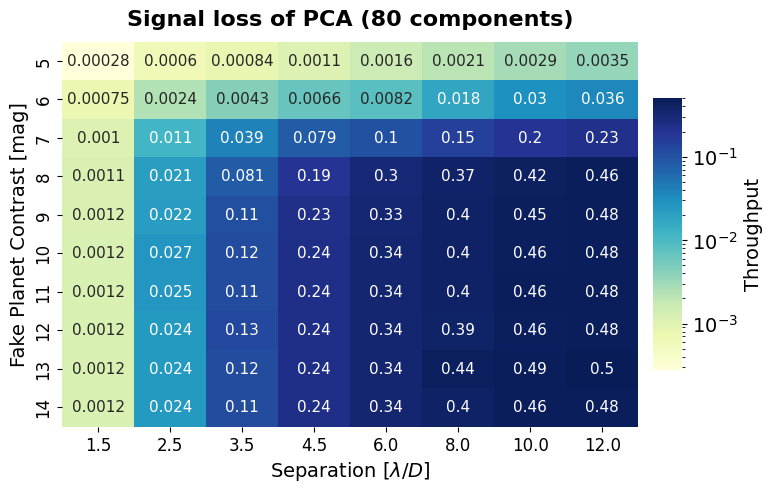

In [151]:
# 1. Create the plot layout ---------------------------------------
fig = plt.figure(constrained_layout=False, figsize=(8, 5))

gs0 = fig.add_gridspec(1, 2, width_ratios = [1, 0.05])
gs0.update(wspace=0.05)

gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 1, subplot_spec = gs0[0],
    hspace=0.12)
gs2 = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec = gs0[1],
    height_ratios=[0.1, 0.8, 0.1])

throughput_ax1 = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs2[1])

# 2. Plot the throughput table ------------------------------------
plot_throughput(throughput_ax1, throughput_results,
                color_bar=False)
throughput_ax1.tick_params(
    axis='both', which='major', labelsize=12)

# 3. Create the colorbar ------------------------------------------
cbar = throughput_ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
throughput_ax1.figure.axes[-1].yaxis.label.set_size(14)

# 4. Labels -------------------------------------------------------
throughput_ax1.set_ylabel(
    r"Fake Planet Contrast [mag]", size=14)
throughput_ax1.set_xlabel(
    r"Separation [$\lambda /D$]", size=14)

throughput_ax1.set_title("Signal loss of PCA (80 components)", y=1.02, size=16, fontweight="bold")

fig.patch.set_facecolor('white')
plt.savefig("./final_plots/04_Throughput.pdf", bbox_inches='tight')